# Simple *gibbs* use case example

## 0. Necessary imports

In [116]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import corner
import airing
import ptemcee

## 1. Generation of toy data

Consider a sine wave of amplitude $A$ and frequency $f_0$ buried into white Gaussian noise.

In [117]:
# Amplitude
a = 2.0
# Frequency
f_0 = 0.12156
# Phase
phi_0 = 0.0
# Observation duration
t_obs = 200
# Sampling frequency
f_s = 2.0
# Data size
size = int(f_s * t_obs)
# Noise standard deviation
sigma = 2.0
# Time vector
t = np.arange(0, size) / f_s
# Signal
wave = a * np.sin(2*np.pi*f_0*t + phi_0)
# Noise
noise = np.random.normal(loc=0, scale=sigma, size=size)
# Observed data
dat = wave + noise

In [118]:
# Check the signal-to-noise ratio
dat_dft = np.fft.fft(dat)
wav_dft = np.fft.fft(wave)
dat_dft_norm = dat_dft * 2 / size
wav_dft_norm = wav_dft * 2 / size
freq = np.fft.fftfreq(size) * f_s

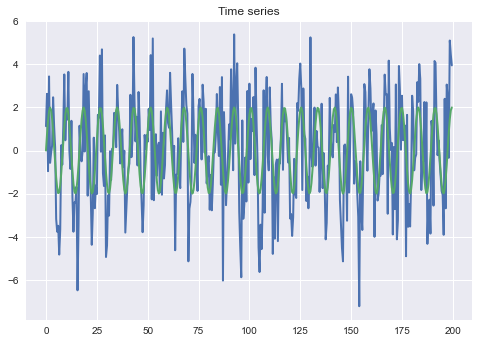

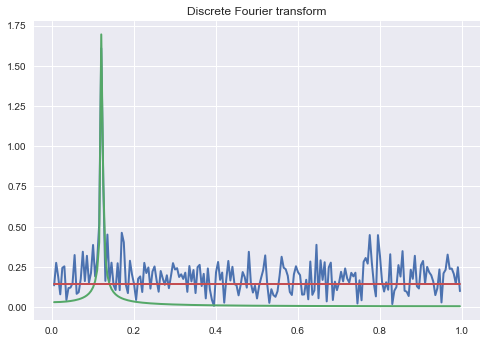

In [119]:

# Visualization
plt.style.use('seaborn')
# plot
fig, ax = plt.subplots()
ax.set_title("Time series")
ax.plot(t, dat, linewidth=2, label='data')
ax.plot(t, wave, linewidth=2, label='signal')
plt.show()

fig, ax = plt.subplots()
ax.set_title("Discrete Fourier transform")
ax.plot(freq[freq>0], np.abs(dat_dft_norm[freq>0]), linewidth=2, label='data')
ax.plot(freq[freq>0], np.abs(wav_dft_norm[freq>0]), linewidth=2, label='signal')
ax.plot(freq[freq>0], np.ones(size)[freq>0] * sigma * np.sqrt(2 / size), linewidth=2, label='noise level')
plt.show()


In [120]:
print(freq[1])
print(a)
print(f_0)

0.005
2.0
0.12156


## 2. Definition of the model likelihood

We need to define a model likelihood that distinguishes between to kinds of parameters. Here, the frequency parameter (which appears non-linearly in the signal) is referred to as the intrinsic parameter. The amplitude of the wave is the extrinsic parameter.

We will sample the parameters using a PTMCMC embeded in a Gibbs sampler. Hence, the algorithm will alternate between two steps:

1. Sample for $f_0 \sim p(f_0 | A, y)$
2. Sample for $A \sim p(A |f_0, y)$

We will perform the first step using the PTMCMC algorithm. We will perform the second step using the conditional probability of $A$, based on the fact that it follows a normal distribution:

$p(A |f_0, y) = {N}(\mu_{|f_0, y}, \sigma^{2}_{|f_0, y})$

In [121]:
# Define a Gaussian likelihood
class GaussianLikelihood:

    def __init__(self, time, data, sigma, phi_0=phi_0):

        self.time = time
        self.fs = 1 / (time[1] - time[0])
        self.data = data
        self.sigma = sigma
        self.phi_0 = phi_0
        self.size = data.shape[0]
        self.norm = - self.size / 2 * np.log(2 * np.pi)
        # self.data_dft = dat_dft * np.sqrt(2 / (self.fs*self.size))
        # self.sigma_dft = self.sigma * np.sqrt(2/self.fs)
        
    def loglike(self, params):

        frequency = params[0]
        amplitude = params[1]

        mu = amplitude * np.sin(2*np.pi*frequency*self.time + self.phi_0)

        return - 0.5 * np.sum(np.abs(self.data - mu)**2 / self.sigma**2) + self.norm

In [122]:
# Instantiate the likelihood
ll_cls = GaussianLikelihood(t, dat, sigma, phi_0=phi_0)
# Test likelihood
print(ll_cls.loglike([f_0, a]))

-565.1740046382556


In [123]:
print(1/t_obs)

0.005


In [124]:
df_vect = np.arange(f_0 - 5/ t_obs, f_0 + 5 / t_obs, 0.0001)
ll_values_f= np.array([ll_cls.loglike(np.concatenate([[df], [a]])) for df in df_vect])
i_max = np.argmax(ll_values_f)

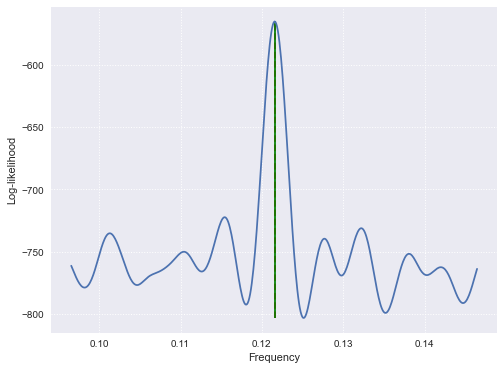

In [125]:
fix, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(df_vect, ll_values_f, marker='+')
ax.legend(loc='upper left')
ax.vlines(df_vect[i_max], 
          np.min(ll_values_f), 
          ll_values_f[i_max], 
          color='red', 
          linestyle='dashed')
ax.vlines(f_0, 
np.min(ll_values_f), 
ll_cls.loglike(np.concatenate([[f_0], [a]])), 
color='green', 
linestyle='solid')
ax.set_xlabel(r"Frequency")
ax.set_ylabel("Log-likelihood")
ax.grid(linestyle='dotted')
plt.show()

## 3. Definition of the prior

In [126]:
# We need a Gaussian prior
def logp(x, low_f, high_f, mu_0, sigma_0):
    # Uniform prior for the frequency
    if (x[0] >= low_f) & (x[0] <= high_f):
        # Gaussian prior for the amplitude
        return - 0.5 * np.sum(((x-mu_0)/sigma_0)**2)
    else:
        return - np.inf

# Define the prior bounds for all parameters (frequency, amplitude)
low_f = 1 / t_obs # f_0 - 5 / t_obs
high_f = f_s / 2 # f_0 + 5 / t_obs
lower_bounds =  np.array([low_f, -10.0])
upper_bounds = np.array([high_f, 10.0])
mu_0 = 0
sigma_0 = (upper_bounds[1] - lower_bounds[1]) / 3
print(sigma_0)
print(lower_bounds)
print(upper_bounds)

6.666666666666667
[ 5.e-03 -1.e+01]
[ 1. 10.]


## 4. Run a classic sampler

In [127]:
nwalkers = 100
ndim = 2
ndim1 = 1
ndim2 = 1
ntemps = 4

# Initialize all parameters
p_0 = np.random.uniform(lower_bounds, upper_bounds, size=(ntemps, nwalkers, ndim))

In [128]:
# Start sampling
sampler = ptemcee.Sampler(nwalkers, ndim, ll_cls.loglike, logp, 
                          logpargs=[low_f, high_f, mu_0, sigma_0], 
                          ntemps=ntemps)


In [129]:
n_iter = 1000
n_thin = 1
result = sampler.run_mcmc(p_0[:], iterations=n_iter, thin=n_thin)

In [130]:
sampler.chain.shape

(4, 100, 1000, 2)

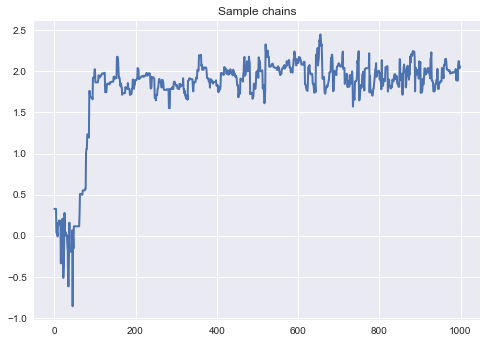

In [131]:
# check the chains
fig, ax = plt.subplots()
ax.set_title("Sample chains")
ax.plot(sampler._chain[0, 0, :, 1], linewidth=2, label='chain')
plt.show()

In [132]:
burnin = 500
samples_plot = sampler._chain[0, :, burnin:, :].reshape((nwalkers*(sampler._chain.shape[2]-burnin), sampler._chain.shape[-1]))

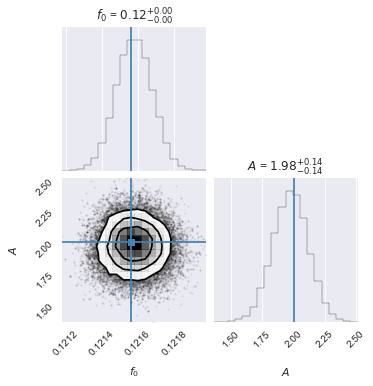

In [134]:
# Plot it.
figure = corner.corner(samples_plot, labels=[r"$f_0$", r"$A$"],
                       show_titles=True, 
                       truths=[f_0, a],
                       title_kwargs={"fontsize": 12})

## 5. Run a MCMC within-Gibbs sampler

Now the frequency is the main parameter that will be sampled through PTMCMC, and the amplitude is considered an auxiliary parameter, and will be sampled using an explicit Gibbs conditional step. 

In [135]:
# Define a Gaussian likelihood depending ONLY on frequency
class GaussianLikelihoodGibbs:

    def __init__(self, time, data, sigma, phi_0=phi_0):

        self.time = time
        self.fs = 1 / (time[1] - time[0])
        self.data = data
        self.sigma = sigma
        self.phi_0 = phi_0
        self.size = data.shape[0]
        self.norm = - self.size / 2 * np.log(2 * np.pi)
        
    def loglike(self, frequency, amplitude):

        mu = amplitude * np.sin(2*np.pi*frequency*self.time + self.phi_0)

        return - 0.5 * np.sum(np.abs(self.data - mu)**2 / self.sigma**2) + self.norm

In [136]:
# Define a Gaussian conditional step
class ConditionalStep:

    def __init__(self, time, data, sigma, mu_p, sigma_p, phi_0=phi_0):

        self.time = time
        self.data = data
        # Standard deviation of the data
        self.sigma = sigma
        # Mean and standard deviation of the parameter prior
        self.mu_p = mu_p
        self.sigma_p = sigma_p
        # Compute size of time series
        self.size = data.shape[0]
        self.norm = - self.size / 2 * np.log(2 * np.pi)
        self.phi_0 = phi_0

    def ols_amplitude(self, frequency):

        a_model = np.sin(2*np.pi*frequency*self.time + self.phi_0)
        ata = np.sum(a_model ** 2 / self.sigma**2)

        return np.sum(a_model * self.data / self.sigma**2) / ata

    def update_amplitude(self, frequency, amplitude):

        a_model = np.sin(2*np.pi*frequency*self.time + self.phi_0)
        ata = np.sum(a_model ** 2 / self.sigma**2)
        # Conditional variance
        var_a = 1 /  (ata + 1 / self.sigma_p**2)
        # Conditional expectation
        mu_a = (np.sum(a_model * self.data / self.sigma**2) + self.mu_p / self.sigma_p**2) * var_a

        return np.random.normal(loc=mu_a, scale=np.sqrt(var_a))

In [137]:
# We need a Gaussian prior
def logp_freq(x, low_f, high_f):
    # Uniform prior for the frequency
    if (x >= low_f) & (x <= high_f):
        return 0.0
    else:
        return - np.inf

In [138]:
print(low_f, high_f)

0.005 1.0


In [139]:
# Instantiate the likelihood
ll_cls = GaussianLikelihoodGibbs(t, dat, sigma, phi_0=phi_0)
# Instantiate the Gibbs update function
gibbs_cls = ConditionalStep(t, dat, sigma, mu_0, sigma_0, phi_0=phi_0)

In [140]:
# Initialize primary and auxiliary parameters
nwalkers = 100
ndim = 2
ndim1 = 1
ndim2 = 1
ntemps = 4

# Initialize the frequency parameter
p1_0 = np.random.uniform(lower_bounds[0], upper_bounds[0], size=(ntemps, nwalkers, ndim1))
# Initialize the amplitude parameter
p2_0 = np.array([[gibbs_cls.update_amplitude(p1_0[0, i, :], 1.0)] for i in range(nwalkers)])

In [142]:
n_save = 200
n_update = 1
n_start_update = 0
n_iter = 2000

sampler = airing.Sampler(nwalkers, ndim1, ll_cls.loglike, logp_freq,
                 ntemps=ntemps, Tmax=None, betas=None,
                 gibbs=gibbs_cls.update_amplitude,
                 dim2=ndim2,
                 threads=1, pool=None, a=2.0,
                 loglargs=[], logpargs=[low_f, high_f], gibbsargs=[],
                 loglkwargs={}, logpkwargs={}, gibbskwargs={})

In [143]:
result = sampler.run(n_iter, n_save, n_thin,
                        n_update=n_update,
                        n_start_update=n_start_update,
                        pos0=p1_0,
                        aux0=p2_0,
                        save_path="../data/example_",
                        storeaux=True,
                        verbose=200)

Iteration 0 completed.
Save data at iteration 200...
Data saved.
Iteration 200 completed.
Save data at iteration 400...
Data saved.
Iteration 400 completed.
Save data at iteration 600...
Data saved.
Iteration 600 completed.
Save data at iteration 800...
Data saved.
Iteration 800 completed.
Save data at iteration 1000...
Data saved.
Iteration 1000 completed.
Save data at iteration 1200...
Data saved.
Iteration 1200 completed.
Save data at iteration 1400...
Data saved.
Iteration 1400 completed.
Save data at iteration 1600...
Data saved.
Iteration 1600 completed.
Save data at iteration 1800...
Data saved.
Iteration 1800 completed.
Save data at iteration 1999...
Data saved.


In [144]:
# Get the frequency samples
with open("../data/example_chain.p", "rb") as f_file:
    f_samples = pickle.load(f_file)
# Get the amplitude samples
with open("../data/example_aux.p", "rb") as a_file:
    a_samples = pickle.load(a_file)


In [145]:
print(a_samples.shape)
print(f_samples.shape)

(100, 1999, 1)
(4, 100, 1999, 1)


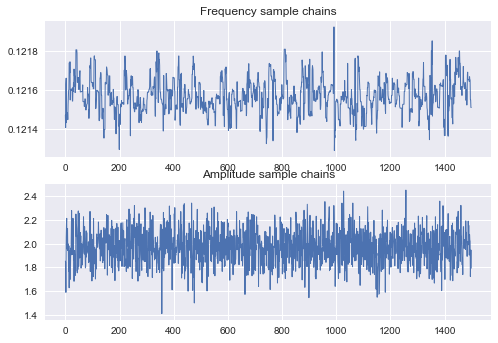

In [146]:
# check the chains
start = 500
walker = 1
fig, ax = plt.subplots(2)
ax[0].set_title("Frequency sample chains")
ax[0].plot(f_samples[0, walker, start:, 0], linewidth=1, label='chain')
ax[1].set_title("Amplitude sample chains")
ax[1].plot(a_samples[walker, start:, 0], linewidth=1, label='chain')
plt.show()

In [147]:
# Concatenate frequency and amplitude samples
samples = np.concatenate([f_samples[0, :, :, :], a_samples[:, :, :]], axis=2)
burnin = 200
samples_plot = samples[:, burnin:, :].reshape((nwalkers*(samples.shape[1]-burnin), samples.shape[-1]))
samples_plot_f = f_samples[0, :, burnin:, :].reshape((nwalkers*(f_samples.shape[2]-burnin), f_samples.shape[-1]))
samples_plot_a = a_samples[:, burnin:, :].reshape((nwalkers*(f_samples.shape[1]-burnin), a_samples.shape[-1]))

In [148]:
print(f_samples.shape)
print(samples_plot_f.shape)

(4, 100, 1999, 1)
(179900, 1)


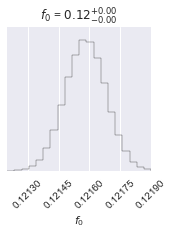

In [149]:
# Amplitude samples
figure = corner.corner(samples_plot_f, labels=[r"$f_0$"],
                       range=[[0.1212, 0.1219]],
                       show_titles=True, title_kwargs={"fontsize": 12})

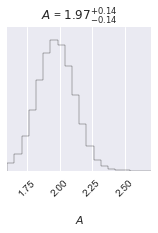

In [150]:
# Amplitude samples
figure = corner.corner(samples_plot_a, labels=[r"$A$"], 
                       range=[[1.6, 2.7]],
                       show_titles=True, title_kwargs={"fontsize": 12})

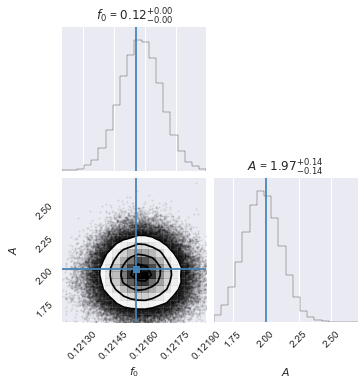

In [151]:
# Plot it.
figure = corner.corner(samples_plot, labels=[r"$f_0$", r"$A$"],
                       range=[[0.1212, 0.1219], [1.6, 2.7]],
                       truths=[f_0, a],
                       show_titles=True, title_kwargs={"fontsize": 12})